In [1]:
import requests
import geopandas as gpd
import osmnx as ox
import networkx as nx
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from shapely.geometry import Point, Polygon

sns.set()
ox.config(use_cache=True, log_console=True)

2022-09-05 13:27:46 Configured OSMnx 1.1.2
2022-09-05 13:27:46 HTTP response caching is on


### Request Data from Yelp

Request top coffee roasters by rating in San Francisco on Yelp:

In [2]:
url = "https://api.yelp.com/v3/businesses/search"
url_params = {
    "term": "coffee",
    "location": "San Francisco, CA",
    "limit": 20,
    "categories": "Coffee Roasteries",
    "sort_by": "rating",
}

with open("api_key.txt", "r") as f:
    api_key = f.read()
headers = {
    "Authorization": f"Bearer {api_key}",
}

In [3]:
response = requests.get(url, headers=headers, params=url_params)
d = response.json()

In [4]:
latitudes = [
    d.get("businesses")[x].get("coordinates").get("latitude")
    for x in range(url_params["limit"])
]
longitudes = [
    d.get("businesses")[x].get("coordinates").get("longitude")
    for x in range(url_params["limit"])
]
geom = [Point(xy) for xy in zip(longitudes, latitudes)]
name = [d.get("businesses")[x].get("name") for x in range(url_params["limit"])]
df = gpd.GeoDataFrame(name, columns=["name"], geometry=geom)

Remove any points outside of the city, if there are any bad latitude and longitudes:

In [5]:
poly = Polygon(
    [(-122.360, 37.81), (-122.515, 37.81), (-122.515, 37.707), (-122.360, 37.707)]
)
df = df[[poly.contains(x) for x in df.geometry]]
df = df.set_crs("epsg:4326").head(10)
df

,name,geometry
0,Home Coffee Roasters,POINT (-122.47701 37.75445)
1,Flywheel Coffee Roasters,POINT (-122.45351 37.76968)
2,The Coffee Movement,POINT (-122.41030 37.79483)
3,Spike's Coffees & Teas,POINT (-122.43503 37.75916)
4,Andytown Coffee Roasters,POINT (-122.50228 37.75680)
5,The Mill,POINT (-122.43775 37.77648)
6,Souvenir Coffee,POINT (-122.43696 37.77161)
7,Sightglass Coffee,POINT (-122.43751 37.77232)
8,SPRO Coffee Lab,POINT (-122.42867 37.76281)
9,Compton's Coffee House,POINT (-122.43328 37.78743)


### Build Open Street Maps Graph

Create a NetworkX graph using bike route data from Open Street Maps.

In [6]:
g = ox.graph.graph_from_bbox(37.81, 37.707, -122.360, -122.515, network_type="bike")
g = ox.distance.add_edge_lengths(g)
g = ox.speed.add_edge_speeds(g)
g = ox.speed.add_edge_travel_times(g)

2022-09-05 13:27:46 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-09-05 13:27:46 Projected GeoDataFrame to epsg:4326
2022-09-05 13:27:47 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-09-05 13:27:47 Projected GeoDataFrame to epsg:4326
2022-09-05 13:27:47 Requesting data within polygon from API in 1 request(s)
2022-09-05 13:27:47 Retrieved response from cache file "cache/1f8cb5a2878bfbadd9e4af2326109b043ea35844.json"
2022-09-05 13:27:47 Got all network data within polygon from API in 1 request(s)
2022-09-05 13:27:47 Creating graph from downloaded OSM data...
2022-09-05 13:27:49 Created graph with 96821 nodes and 180972 edges
2022-09-05 13:27:51 Added length attributes to graph edges
2022-09-05 13:27:51 Identifying all nodes that lie outside the polygon...
2022-09-05 13:27:54 Created nodes GeoDataFrame from graph
2022-09-05 13:27:57 Created r-tree spatial index for 96821 geo

### Set Up and Solve the Traveling Salesman Problem

In [7]:
df.loc[:, "nearest_node"] = df.geometry.apply(
    lambda pt: ox.distance.nearest_nodes(g, pt.x, pt.y)
)
df.loc[:, "key"] = 0
pr = df.merge(df, on="key", suffixes=("_from", "_to"))
pr["dist"] = pr.apply(
    lambda x: nx.shortest_path_length(
        g, source=x.nearest_node_from, target=x.nearest_node_to, weight="length"
    ),
    axis=1,
)

2022-09-05 13:28:21 Created nodes GeoDataFrame from graph
2022-09-05 13:28:21 Created nodes GeoDataFrame from graph
2022-09-05 13:28:21 Created nodes GeoDataFrame from graph
2022-09-05 13:28:21 Created nodes GeoDataFrame from graph
2022-09-05 13:28:21 Created nodes GeoDataFrame from graph
2022-09-05 13:28:21 Created nodes GeoDataFrame from graph
2022-09-05 13:28:21 Created nodes GeoDataFrame from graph
2022-09-05 13:28:21 Created nodes GeoDataFrame from graph
2022-09-05 13:28:21 Created nodes GeoDataFrame from graph
2022-09-05 13:28:22 Created nodes GeoDataFrame from graph


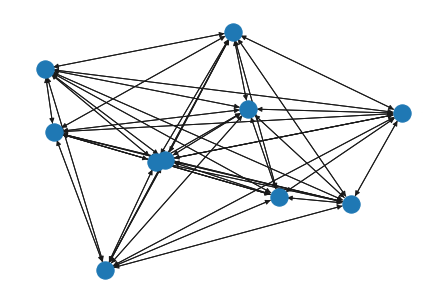

In [8]:
# make simplified graph for faster execution
sg = nx.DiGraph()
sg.add_nodes_from(df.index)
name2node = dict(zip(df.name, df.index))
node2nn = dict(zip(df.index, df.nearest_node))
node2name = dict(zip(df.index, df.name))
for idx, row in pr.loc[pr["name_from"] != pr["name_to"]].iterrows():
    sg.add_edge(
        name2node[row["name_from"]], name2node[row["name_to"]], weight=row["dist"]
    )
nx.draw(sg)

In [9]:
path = nx.approximation.traveling_salesman_problem(sg, cycle=False)
[node2name[x] for x in path]

['Flywheel Coffee Roasters',
 'Sightglass Coffee',
 'Souvenir Coffee',
 'The Mill',
 "Compton's Coffee House",
 'The Coffee Movement',
 'SPRO Coffee Lab',
 "Spike's Coffees & Teas",
 'Home Coffee Roasters',
 'Andytown Coffee Roasters']

In [10]:
full_path = []
node_path = [node2nn[x] for x in path]
for i in range(len(path) - 1):
    if i == 0:
        full_path += nx.shortest_path(
            g, node_path[i], node_path[i + 1], weight="length"
        )
    else:
        full_path += nx.shortest_path(
            g, node_path[i], node_path[i + 1], weight="length"
        )[1:]

### Travel Distance in Miles

In [11]:
sum([g[full_path[i]][full_path[i+1]][0]["length"] for i in range(len(full_path) - 1)]) * 0.000621371

12.394910490651002

### Visualizing the Route

In [12]:
path

[1, 7, 6, 5, 9, 2, 8, 3, 0, 4]

In [35]:
# slightly tweak geometry for plotting
df.loc[:, "tweaked_geom"] = df.geometry.apply(
    lambda x: Point((x.xy[0][0], x.xy[1][0] + 0.001))
)
df.loc[8,"tweaked_geom"] = Point((df.loc[8,"tweaked_geom"].xy[0][0] + 0.002, df.loc[8,"tweaked_geom"].xy[1][0] - 0.001))
df.loc[5,"tweaked_geom"] = Point((df.loc[5,"tweaked_geom"].xy[0][0] - 0.002, df.loc[5,"tweaked_geom"].xy[1][0] - 0.002))
df.loc[9,"tweaked_geom"] = Point((df.loc[9,"tweaked_geom"].xy[0][0] - 0.002, df.loc[9,"tweaked_geom"].xy[1][0] + 0.001))
df.loc[7,"tweaked_geom"] = Point((df.loc[7,"tweaked_geom"].xy[0][0] + 0.002, df.loc[7,"tweaked_geom"].xy[1][0] - 0.001))
df.loc[6,"tweaked_geom"] = Point((df.loc[6,"tweaked_geom"].xy[0][0], df.loc[6,"tweaked_geom"].xy[1][0] - 0.004))
rank2order = dict(zip(path, range(len(path))))
df.loc[:, "number"] = [rank2order[x] + 1 for x in df.index]

In [32]:
df

,name,geometry,nearest_node,key,tweaked_geom,number
0,Home Coffee Roasters,POINT (-122.47701 37.75445),8882087370,0,POINT (-122.47701 37.75545),9
1,Flywheel Coffee Roasters,POINT (-122.45351 37.76968),65361720,0,POINT (-122.45351 37.77068),1
2,The Coffee Movement,POINT (-122.41030 37.79483),65310923,0,POINT (-122.41030 37.79583),6
3,Spike's Coffees & Teas,POINT (-122.43503 37.75916),65293652,0,POINT (-122.43503 37.76016),8
4,Andytown Coffee Roasters,POINT (-122.50228 37.75680),65294075,0,POINT (-122.50228 37.75780),10
5,The Mill,POINT (-122.43775 37.77648),5433622906,0,POINT (-122.43975 37.77548),4
6,Souvenir Coffee,POINT (-122.43696 37.77161),65327914,0,POINT (-122.43696 37.77061),3
7,Sightglass Coffee,POINT (-122.43751 37.77232),259138835,0,POINT (-122.43551 37.77232),2
8,SPRO Coffee Lab,POINT (-122.42867 37.76281),65317406,0,POINT (-122.42667 37.76281),7
9,Compton's Coffee House,POINT (-122.43328 37.78743),65341798,0,POINT (-122.43528 37.78943),5


In [33]:
# set up figure aesthetics
font_dir = [
    "/Users/katherinementzer/Library/Group Containers/UBF8T346G9.Office/FontCache/4/CloudFonts/Aharoni"
]
for font in matplotlib.font_manager.findSystemFonts(font_dir):
    matplotlib.font_manager.fontManager.addfont(font)
rcParams["font.family"] = "Aharoni"
sns.set_style(
    {"axes.facecolor": "#C6A992", "figure.facecolor": "#C6A992"}
)  # latte brown colorcodes.io

2022-09-05 13:44:12 Begin plotting the graph...
2022-09-05 13:44:15 Created edges GeoDataFrame from graph


/Users/katherinementzer/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/geopandas/plotting.py:467: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.draw()


2022-09-05 13:44:22 Finished plotting the graph


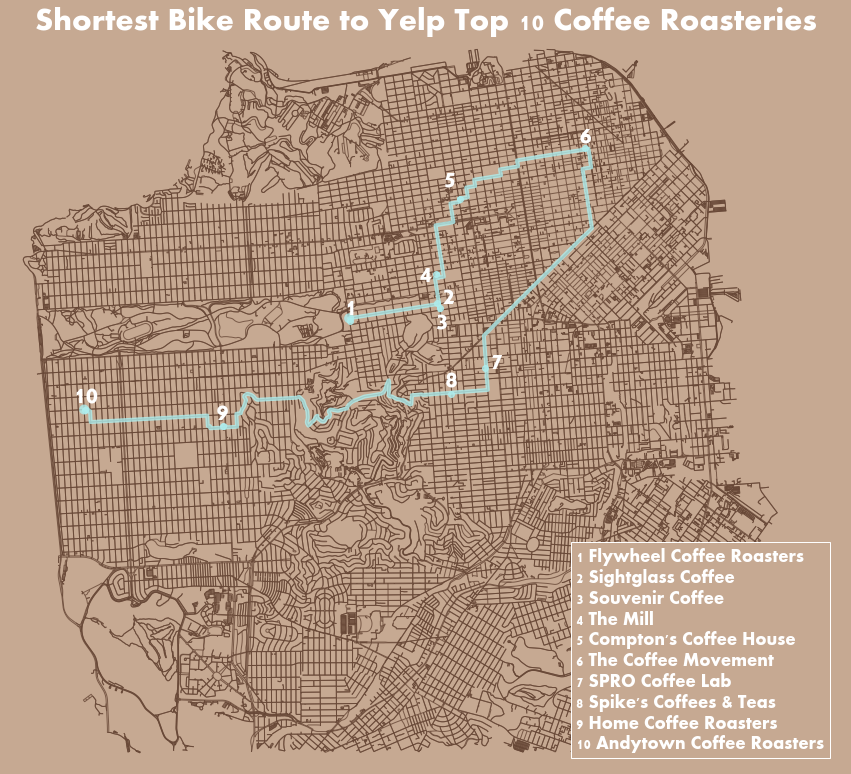

In [37]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
ox.plot.plot_graph(
    g, node_size=0, ax=ax, show=False, close=False, edge_alpha=0.8, edge_color="#674736"
)
ox.plot.plot_graph_route(
    g, full_path, ax=ax, show=False, close=False, route_color="#AFEEEE", route_alpha=0.8
)

for i, row in df.iterrows():
    plt.scatter(
        [row.geometry.coords[0][0]],
        [row.geometry.coords[0][1]],
        c="#AFEEEE",
        alpha=0.8,
    )


label = ""
for idx in path:
    label += f"{df.loc[idx, 'number']} {df.loc[idx, 'name']}\n"

df.apply(
    lambda x: ax.annotate(
        fontsize=32,
        text=x.number,  # x["name"].lower(),
        xy=x.tweaked_geom.coords[0],
        ha="center",
        c="white",
        fontweight=8,
    ),
    axis=1,
)
ax.annotate(
    label[:-1],
    xy=(0.68, 0.3),
    xycoords="axes fraction",
    size=18,
    ha="left",
    va="top",
    c="white",
    bbox=dict(boxstyle="square", fc="#C6A992"),
)
plt.title(
    "Shortest Bike Route to Yelp Top 10 Coffee Roasteries", fontsize=32, c="white"
)
plt.savefig("bike_route.jpg")

### Streets Taken on Route

In [38]:
my_list = [
    g[full_path[i]][full_path[i + 1]][0]["name"]
    for i in range(len(full_path) - 1)
    if "name" in g[full_path[i]][full_path[i + 1]][0]
]
seen = set()
seen_add = seen.add
[x for x in my_list if not (str(x) in seen or seen_add(str(x)))]

['Page Street',
 'Divisadero Street',
 'Haight Street',
 'Grove Street',
 'Scott Street',
 'Geary Boulevard',
 'Steiner Street',
 'Bush Street',
 'Fillmore Street',
 'Wilmot Street',
 'Webster Street',
 'California Street',
 'Buchanan Street',
 'Sacramento Street',
 'Gough Street',
 'Clay Street',
 'Van Ness Bus Rapid Transit',
 'Washington Street',
 'Powell Street',
 'Mason Street',
 'Market Street',
 'Church Street',
 '19th Street',
 'Yukon Street',
 'Short Street',
 'Clayton Street',
 'Twin Peaks Boulevard',
 'Clarendon Avenue',
 'Christopher Drive',
 'Crestmont Drive',
 'Devonshire Way',
 'Warren Drive',
 'Lawton Street',
 'Lomita Avenue',
 '16th Avenue',
 'Moraga Street',
 '17th Avenue',
 'Noriega Street',
 '19th Avenue',
 '22nd Avenue',
 '42nd Avenue']